In [1]:
import pandas as pd
import cv2
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import re
import plotly.express as px
from keras.callbacks import EarlyStopping
from scipy import stats
from tqdm import tqdm

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.get_logger().setLevel('INFO')

Num GPUs Available:  1


Dataset: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

# Análisis exploratorio

In [3]:
df = pd.read_csv('archive/metadata.csv')
df.head()

Unnamed: 0            image  class format mode          shape
0           0   Cancer (1).jpg  tumor   JPEG  RGB  (512, 512, 3)
1           1   Cancer (1).png  tumor    PNG    L     (300, 240)
2           2   Cancer (1).tif  tumor   TIFF  RGB  (256, 256, 3)
3           3  Cancer (10).jpg  tumor   JPEG  RGB  (512, 512, 3)
4           4  Cancer (10).tif  tumor   TIFF  RGB  (256, 256, 3)

## Limpieza del dataset

In [4]:
def str2list(string):
    return re.sub(r"[\(\)]", "", string).split(",")

In [5]:
df["shape"] = df["shape"].apply(str2list)

In [6]:
shapes = pd.DataFrame(df["shape"].to_list(), columns=['width', 'height', "channels"])
shapes = shapes.fillna(1)
shapes = shapes.astype("int32")

In [7]:
for shape in ["width", "height", "channels"]:
    df[shape] = shapes[shape]
df = df.drop(['Unnamed: 0', "shape"], axis=1)
df

image   class format mode  width  height  channels
0            Cancer (1).jpg   tumor   JPEG  RGB    512     512         3
1            Cancer (1).png   tumor    PNG    L    300     240         1
2            Cancer (1).tif   tumor   TIFF  RGB    256     256         3
3           Cancer (10).jpg   tumor   JPEG  RGB    512     512         3
4           Cancer (10).tif   tumor   TIFF  RGB    256     256         3
...                     ...     ...    ...  ...    ...     ...       ...
4595  Not Cancer  (995).jpg  normal   JPEG  RGB    168     300         3
4596  Not Cancer  (996).jpg  normal   JPEG  RGB    509     452         3
4597  Not Cancer  (997).jpg  normal   JPEG  RGB    197     177         3
4598  Not Cancer  (998).jpg  normal   JPEG  RGB    217     232         3
4599  Not Cancer  (999).jpg  normal   JPEG  RGB    221     228         3

[4600 rows x 7 columns]

In [8]:
df.shape

(4600, 7)

In [9]:
df["class"].value_counts()

tumor     2513
normal    2087
Name: class, dtype: int64

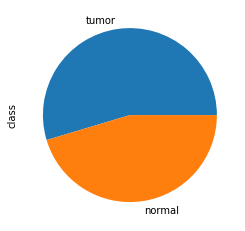

In [10]:
df['class'].value_counts().plot.pie();

In [11]:
df["mode"].unique()

array(['RGB', 'L', 'RGBA', 'P'], dtype=object)

In [12]:
df[df["mode"]=="P"]

image   class format mode  width  height  channels
4129  Not Cancer  (576).jpg  normal    PNG    P    725     728         1
4581  Not Cancer  (982).jpg  normal    PNG    P    725     728         1

In [13]:
df[df["mode"]=="L"]

image   class format mode  width  height  channels
1            Cancer (1).png   tumor    PNG    L    300     240         1
36        Cancer (1028).jpg   tumor   JPEG    L    336     300         1
239       Cancer (1209).jpg   tumor   JPEG    L    336     300         1
269       Cancer (1236).jpg   tumor   JPEG    L   1024    1024         1
293       Cancer (1258).jpg   tumor   JPEG    L   1427    1275         1
...                     ...     ...    ...  ...    ...     ...       ...
4561  Not Cancer  (964).jpg  normal   JPEG    L    225     225         1
4566  Not Cancer  (969).jpg  normal   JPEG    L   1024    1024         1
4571  Not Cancer  (973).jpg  normal   JPEG    L    275     220         1
4577  Not Cancer  (979).jpg  normal   JPEG    L    301     275         1
4583  Not Cancer  (984).jpg  normal   JPEG    L    442     409         1

[132 rows x 7 columns]

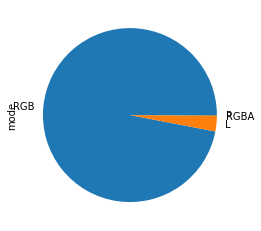

In [14]:
df['mode'].value_counts().plot.pie();

In [15]:
fig = px.box(df, y=["width", "height"], title="Dimensiones de las imagenes")
fig.show()

In [16]:
df[df["height"] < 927].describe()

width       height     channels
count  4549.000000  4549.000000  4549.000000
mean    370.018246   350.834469     2.951858
std     153.598454   154.242167     0.311907
min     167.000000   150.000000     1.000000
25%     236.000000   225.000000     3.000000
50%     337.000000   283.000000     3.000000
75%     512.000000   512.000000     3.000000
max    1075.000000   926.000000     4.000000

# Preprocesamiento

In [18]:
casos = [1586,
2376,
2373,
2326,
184,
1016,
10,
1197,
1469]

In [ ]:
# for i in casos:
    img = cv2.imread("archive/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer ("+ str(i) + ").jpg", 0)
    fig, ax = plt.subplots(2, 3, figsize=(10,10))
    ax[0][0].imshow(img, cmap="gray")
    ax[0][0].set_title("Original")

    img2 = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    ax[0][1].imshow(img2, cmap="gray")
    ax[0][1].set_title("Normalizada")


    img2 = cv2.blur(img2, (3, 3))
    img2 = cv2.fastNlMeansDenoising(img2, None, 20, 7, 21) 


    ax[0][2].imshow(img2, cmap="gray")
    ax[0][2].set_title("Blur y reducción de ruido")

    kernel = np.ones((3, 3), np.uint8)
    img2 = cv2.morphologyEx(img2, cv2.MORPH_GRADIENT, kernel)
    img2 = cv2.equalizeHist(img2)

    ax[1][0].imshow(img2, cmap="gray")
    ax[1][0].set_title("Transformación morofologíca y \n ecualización")
    
    img2 = cv2.threshold(img2, 170, 255, cv2.THRESH_BINARY)[1]
    ax[1][1].imshow(img2, cmap="gray")
    ax[1][1].set_title("Binarización")

#     # Remove padding
#     vert_mean = np.mean(img2, axis=0)
#     vert_map = vert_mean > 1;
#     vert_matches = np.where(vert_map == True)
#     img2 = img2[:, vert_matches[0][0]:vert_matches[0][-1]]
#     # Top & bottom
#     hori_mean = np.mean(img2, axis=1)
#     hori_map = hori_mean > 1;
#     hori_matches = np.where(hori_map == True)
#     img2 = img2[hori_matches[0][0]:hori_matches[0][-1], :]
    
#     # add padding
#     X, Y = img2.shape
#     if X > Y:
#         out_img = np.zeros((X, X))
#         offset = int(np.ceil((X-Y) / 2))
#         out_img[:, offset : (offset + Y)] = img2
#         img2 = out_img
#     else:
#         out_img = np.zeros((Y, Y))
#         offset = int(np.ceil((Y-X) / 2))
#         out_img[offset : (offset + X), :] = img2
#         img2 = out_img
    y_nonzero, x_nonzero = np.nonzero(img2)
    img2 = img2[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
    img2 = cv2.resize(img2, (64, 64))
    ax[1][2].imshow(img2, cmap="gray")
    ax[1][2].set_title("Eliminación de bandas negras y \n reescalado")
    plt.figure()


<Figure size 432x288 with 0 Axes>

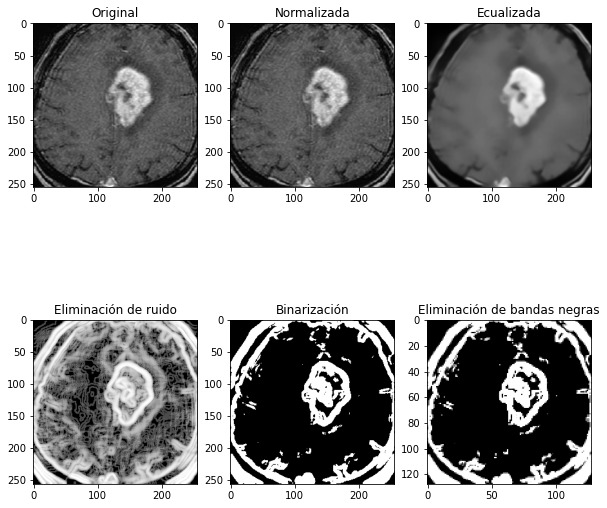

<Figure size 432x288 with 0 Axes>

In [20]:
img = cv2.imread("archive/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif", 0)
fig, ax = plt.subplots(2, 3, figsize=(10,10))
ax[0][0].imshow(img, cmap="gray")
ax[0][0].set_title("Original")

img2 = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
ax[0][1].imshow(img2, cmap="gray")
ax[0][1].set_title("Normalizada")


img2 = cv2.blur(img2, (3, 3))
img2 = cv2.fastNlMeansDenoising(img2, None, 20, 7, 21) 


ax[0][2].imshow(img2, cmap="gray")
ax[0][2].set_title("Ecualizada")

hist = cv2.calcHist([img2],[0],None,[255],[0,256])
#if np.argmax(hist[100:])+100 < 150:
kernel = np.ones((3, 3), np.uint8)
img2 = cv2.morphologyEx(img2, cv2.MORPH_GRADIENT, kernel)
img2 = cv2.equalizeHist(img2)

ax[1][0].imshow(img2, cmap="gray")
ax[1][0].set_title("Eliminación de ruido")

img2 = cv2.threshold(img2, 180, 255, cv2.THRESH_BINARY)[1]
ax[1][1].imshow(img2, cmap="gray")
ax[1][1].set_title("Binarización")

y_nonzero, x_nonzero = np.nonzero(img2)
img2 = img2[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
img2 = cv2.resize(img2, (128, 128))
ax[1][2].imshow(img2, cmap="gray")
ax[1][2].set_title("Eliminación de bandas negras")
plt.figure()

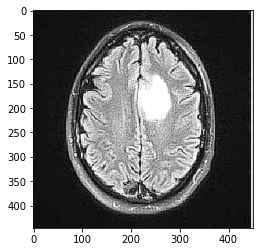

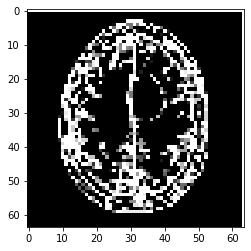

In [58]:
def preprocessing(img, kernel):
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    img = cv2.blur(img, (3, 3))
    img = cv2.fastNlMeansDenoising(img, None, 20, 7, 21) 
    img = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
    img = cv2.equalizeHist(img)
    img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)[1]
#      # Remove padding
#     vert_mean = np.mean(img, axis=0)
#     vert_map = vert_mean > 1;
#     vert_matches = np.where(vert_map == True)
#     img = img[:, vert_matches[0][0]:vert_matches[0][-1]]
#     # Top & bottom
#     hori_mean = np.mean(img, axis=1)
#     hori_map = hori_mean > 1;
#     hori_matches = np.where(hori_map == True)
#     img = img[hori_matches[0][0]:hori_matches[0][-1], :]
    
#     # add padding
#     X, Y = img.shape
#     if X > Y:
#         out_img = np.zeros((X, X))
#         offset = int(np.ceil((X-Y) / 2))
#         out_img[:, offset : (offset + Y)] = img
#         img = out_img
#     else:
#         out_img = np.zeros((Y, Y))
#         offset = int(np.ceil((Y-X) / 2))
#         out_img[offset : (offset + X), :] = img
#         img = out_img
    y_nonzero, x_nonzero = np.nonzero(img)
    img = img[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
    img = cv2.resize(img, (64, 64))
    return img

img1 = preprocessing(img, np.ones((3, 3), np.uint8))
plt.imshow(img, cmap="gray")
plt.figure()
plt.imshow(img1, cmap="gray")

In [59]:
def tt_split(df):
    for clase in ["normal", "tumor"]:
        path = 'archive/preprocess/'+clase+"/"
        for f in os.listdir(path):
            os.remove(os.path.join(path, f))
    kernel = np.ones((3, 3), np.uint8)
    for i in tqdm(range(len(df["image"]))):
        if df["class"].iloc[i] == "tumor":
            path = "Brain Tumor/"
        elif df["class"].iloc[i] == "normal":
            path = "Healthy/"
        img = cv2.imread("archive/Brain Tumor Data Set/Brain Tumor Data Set/"+path+df["image"].iloc[i], 0)
        img = preprocessing(img, kernel)
        cv2.imwrite("archive/preprocess/"+df["class"].iloc[i]+"/"+df["image"].iloc[i], img)

In [60]:
tt_split(df)

100%|██████████| 4600/4600 [14:48<00:00,  5.18it/s]


import os

def image2df():
    df = pd.DataFrame(columns=np.append(np.arange(128*128), "type"))
    for clase in ["normal", "tumor"]:
        path = 'archive/preprocess/'+clase+"/"
        for image in os.listdir(path):
            img = cv2.imread(path+image, 0)
            df.loc[len(df)] = np.append(img.flatten(), clase)
    return df

data =  image2df()

data

data.to_csv("images.csv", index=False)

# Modelo

In [84]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                shear_range=0.1,
                                                                fill_mode='constant',
                                                                validation_split = 0.3,
                                                                dtype=tf.float32)

In [85]:
train_dir = "archive/preprocess/"

In [86]:
batch_size = 128

train_generator = generator.flow_from_directory(train_dir,
                                                target_size=(128, 128),
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                shuffle=True,
                                                color_mode="grayscale",
                                                subset="training")

validation_generator = generator.flow_from_directory(train_dir,
                                                     target_size=(128, 128),
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True,
                                                     color_mode="grayscale",
                                                     subset = "validation")

Found 3221 images belonging to 2 classes.
Found 1379 images belonging to 2 classes.


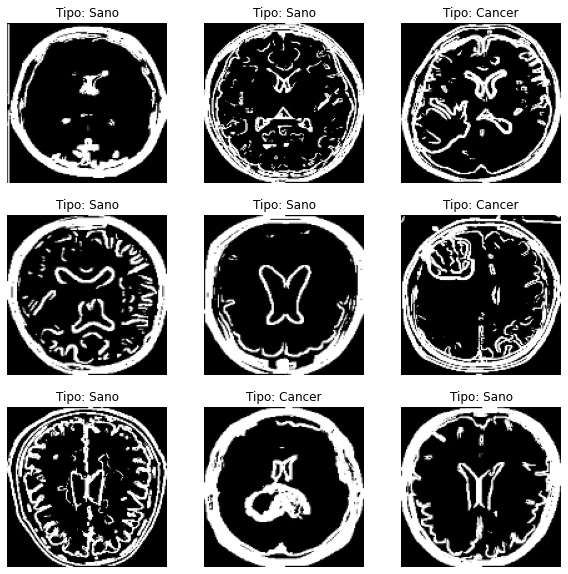

In [87]:
# extraemos un batch
ims, lab = next(train_generator)
tipo = ["Sano", "Cancer"]
plt.figure(figsize=(10, 10))
# mostramos 9 ejemplos
for i in range(9):
    plt.subplot(331+i)
    plt.imshow(ims[i], cmap="gray"); plt.axis("off"); plt.title(f"Tipo: {tipo[int(np.max(lab[i]))]}")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 average_pooling2d_5 (Averag  (None, 63, 63, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_20 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)      

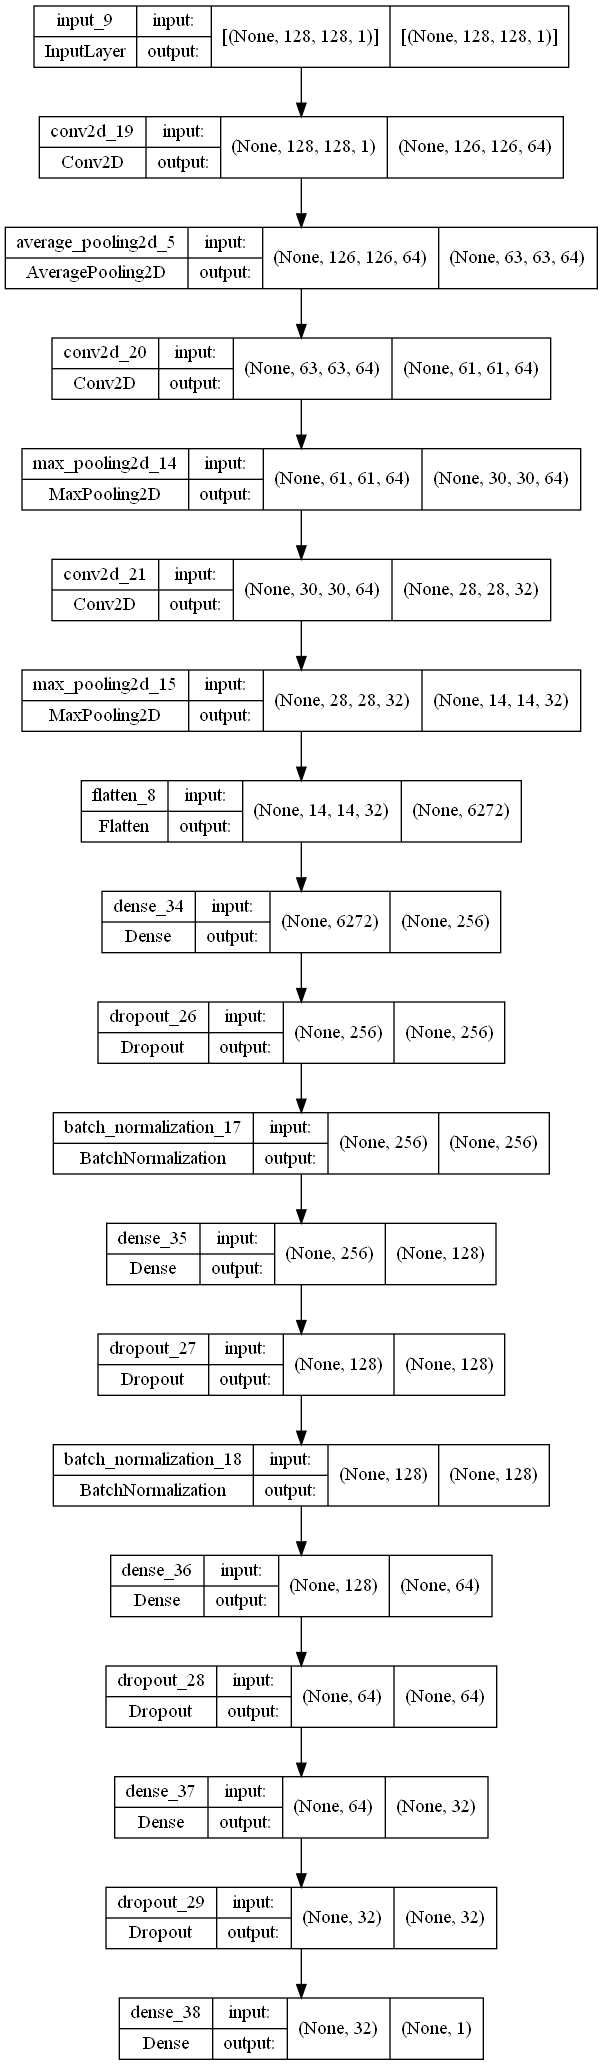

In [92]:
model1 = tf.keras.models.Sequential()
# Input
model1.add(tf.keras.layers.Input(shape=(128, 128, 1)))

# Conv
model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model1.add(tf.keras.layers.AveragePooling2D())

model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model1.add(tf.keras.layers.MaxPooling2D())

model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"))
model1.add(tf.keras.layers.MaxPooling2D())

# Flatten
model1.add(tf.keras.layers.Flatten())

# Clasificador
model1.add(tf.keras.layers.Dense(256, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.Dense(32, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.2))

model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1.compile(loss="binary_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
model1.summary()
tf.keras.utils.plot_model(model1,show_shapes=True)

In [93]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights = True)

# entrenamos el modelo
history = model1.fit(train_generator,
                     steps_per_epoch=train_generator.n//batch_size,  
                     epochs=100,
                     validation_data=validation_generator,
                     validation_steps=validation_generator.n//batch_size,  
                     verbose=1,
                     callbacks=[earlyStopping])

Epoch 1/100
25/25 [==============================] - 11s 380ms/step - loss: 0.6405 - accuracy: 0.6298 - val_loss: 0.7174 - val_accuracy: 0.4734
Epoch 2/100
25/25 [==============================] - 9s 352ms/step - loss: 0.4859 - accuracy: 0.7672 - val_loss: 0.6111 - val_accuracy: 0.7570
Epoch 3/100
25/25 [==============================] - 9s 355ms/step - loss: 0.3932 - accuracy: 0.8215 - val_loss: 0.6059 - val_accuracy: 0.5930
Epoch 4/100
25/25 [==============================] - 9s 352ms/step - loss: 0.2718 - accuracy: 0.8888 - val_loss: 0.7133 - val_accuracy: 0.5477
Epoch 5/100
25/25 [==============================] - 9s 359ms/step - loss: 0.1879 - accuracy: 0.9337 - val_loss: 0.8581 - val_accuracy: 0.5484
Epoch 6/100
25/25 [==============================] - 9s 361ms/step - loss: 0.1355 - accuracy: 0.9521 - val_loss: 0.9079 - val_accuracy: 0.5562
Epoch 7/100
25/25 [==============================] - 9s 349ms/step - loss: 0.0898 - accuracy: 0.9696 - val_loss: 0.8756 - val_accuracy: 0.598

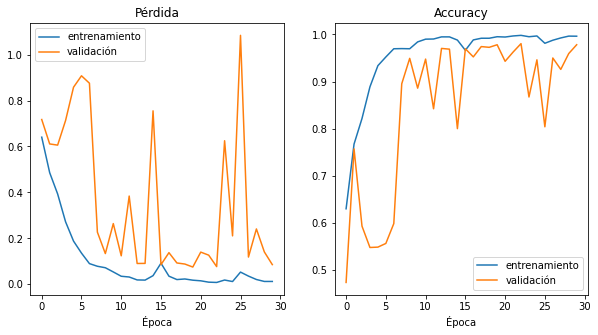

In [94]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history["loss"], label="entrenamiento")
plt.plot(history.history["val_loss"], label="validación")
plt.title("Pérdida"); plt.xlabel("Época"); plt.legend()
plt.subplot(122)
plt.plot(history.history["accuracy"], label="entrenamiento")
plt.plot(history.history["val_accuracy"], label="validación")
plt.title("Accuracy"); plt.xlabel("Época"); plt.legend()

In [95]:
print("Evaluate on validation data")
results = model1.evaluate(validation_generator, batch_size=128)
print("validation loss, validation acc:", results)

Evaluate on validation data
11/11 [==============================] - 3s 249ms/step - loss: 0.0808 - accuracy: 0.9782
validation loss, validation acc: [0.08077064156532288, 0.9782450795173645]


In [70]:
model1.save("modelo 9978.h5")

In [14]:
model1 = tf.keras.models.load_model("modelo 9884.h5")